<a name="section-classification-framework"></a><h2 style="color:rgb(0,120,170)">Classification Average Model as Benchmark</h2>


Given a document, first each word is mapped to its corresponding vector. Then, the word vectors are composed to create the embedding of the document using the *element-wise mean* of the word vectors. Formally, given the document $d$, consisting of words $\left[ v_1, v_2, ..., v_{|d|} \right]$, the document representation $\mathbf{e}_d$ is defined as:

$\mathbf{e}_d = \frac{1}{|d|}\sum_{i=1}^{|d|}{\mathbf{e}_{v_i}}$

where $\mathbf{e}_{v}$ is the vector of the word $v$, and $|d|$ is the length of the document. This document embedding is finally used as features to predict the class (label) of the document.



In [2]:

#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import csv 
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from collections import Counter
from nltk.corpus import stopwords
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import nltk
import time
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW, BertConfig
from keras_preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#disable some annoying warnings
import warnings
warnings.filterwarnings("ignore")

#set displaying cell
pd.set_option('display.max_colwidth', None)

#set plot size
plt.rcParams['figure.figsize'] = [10, 6]

C:\Users\marti\AppData\Roaming\Python\Python38\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [19]:
import torch
# device = torch.device("mps")

#sanity check for gpu
# if torch.backends.mps.is_available(): 
#     device = torch.device("mps")
#     x = torch.ones(1, device=device)
#     print (x)
# else:
#     print ("MPS device not found.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data preprocessing pipeline

In [20]:
start = time.time()
nltk.download('stopwords')
#Preprocessing functions
def cleaning_pipeline(df):
    e_stopwords = stopwords.words('english')
    train_list = df["text"].values.tolist()
    words_without_stopw = []
    for sentence in train_list:
        temp = []
        for word in sentence.lower().split():
            if word not in e_stopwords and  word.isalpha():
                temp.append(word)
        words_without_stopw.append(temp)
    ret_df = pd.DataFrame({"raw_words": words_without_stopw, "label": df.label.values})
    return ret_df

def get_boW(l_of_words,k=100):
    words = set()
    for i in l_of_words:
        counter = Counter(i).most_common(k)
        words.update([i[0] for i in counter])
    return words

#------------------------------------------------------------#

SPLITS = ['train', 'test', "validation"]
datasets = { }

#Load the train, validation, and test sets.
path = "nlpwdl2023_data/thedeep.subset.{}.txt" 
csv_header = ['idx', 'text', 'label']
for split in SPLITS:
        datasets[split] = {}
        datasets[split]['df'] = cleaning_pipeline(pd.read_csv(path.format(split), names = csv_header))

n_label = 12
words = get_boW(datasets["train"]["df"]["raw_words"].values)
#------------------------------------------------------------#
end = time.time()
print(end - start)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1.972611904144287


batch_size= 64 and max_doc_l=50

In [21]:
### Data batching
class M(Dataset):
    
    def __init__(self, dataset, max_doc_l, BoW):
        super().__init__()
        self.dataset = dataset
        self.max_doc_l = max_doc_l
        self.BoW = list(BoW)  


    def __getitem__(self, item):
        ret_val = np.zeros( self.max_doc_l) * len(self.BoW)
        i = 0
        
        for word in  self.dataset["raw_words"][item]:
            if i >= max_doc_l:
                    break
            if word in self.BoW:
                ret_val[i] = self.BoW.index(word) 
                i += 1
            
        return torch.from_numpy(ret_val).type(torch.IntTensor) , self.dataset["label"][item]


    def __len__(self):
        return len(self.dataset)

In [22]:
batch_size = 64
max_doc_l = 50

#----------------------------

train_p = M(datasets["train"]["df"], max_doc_l = max_doc_l, BoW= words)
train_loader = DataLoader(train_p , batch_size=batch_size)
val_p = M(datasets["validation"]["df"], max_doc_l = max_doc_l, BoW= words)
val_loader = DataLoader(val_p , batch_size=batch_size)
test_p = M(datasets["test"]["df"], max_doc_l = max_doc_l, BoW= words)
test_loader = DataLoader(test_p , batch_size=batch_size)

In [23]:
### World Embeddings Lookup
start = time.time()
path = 'word_vectors2.kv'
if os.path.exists(path):
    if not os.path.exists('word2vec-google-news-300'):
        word_vectors = KeyedVectors.load(path)
else:
    #model = api.load("glove-twitter-25")
    model = api.load('word2vec-google-news-300')
    word_vectors = model
    word_vectors.save(path)
end = time.time()
print(end-start)

42.4404616355896


In [24]:
dict_ = {}
dict_[0] = np.full(shape=(300,),fill_value=0)
words = list(words)

for i,word in enumerate(words[1::],1):
     try:
        embedd_w = word_vectors.get_vector(word)
        if min(embedd_w) < min_:
            min_ = min(embedd_w)
        if max(embedd_w) > max_:
            max_ = max(embedd_w)
        dict_[i] = embedd_w
    
     except:
        dict_[i] = np.random.uniform(-3, 3, 300)

dict_keys = np.fromiter(dict_.keys(), dtype=float)
dict_vals = np.array(list(dict_.values()))  

In [25]:
#final embedding used in ALL MODELS
embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(dict_vals))

In [26]:
#one-hot encoding of labels
l_tensor = np.diag(np.ones(n_label))
print(f"tensor label 3:\n", l_tensor[3])

tensor label 3:
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [27]:
class ClassificationAverageModel(torch.nn.Module):
    
    def __init__(self, embedding, n_label):
        
        super(ClassificationAverageModel, self).__init__()
        
        self.embedding = torch.nn.Embedding(num_embeddings = embedding.num_embeddings, embedding_dim = embedding.embedding_dim )
        self.embedding.weight = embedding.weight
        self.transformation = torch.nn.Linear(in_features = embedding.embedding_dim, out_features = n_label, bias=True)
        self.softmax = torch.nn.Softmax(dim=-1)
        
    
    def forward(self, x):
        
        e = self.embedding(x)
        e = torch.sum(e, dim=1)
        counter = torch.tensor(np.count_nonzero(e, axis=0))
        e = torch.div(e, counter)
        e = self.transformation(e)
        return self.softmax(e) #calculates probability distribution of 11 labels
    

In [28]:
#@torch.enable_grad()
def update(dataloader, model, loss, optimizer, l_tensor): 
    device = next(model.parameters()).device
    err = []
    model.train()
    

    for x,y in dataloader:
      
        x, y = x.to(device), y.to(device) #gpu

        optimizer.zero_grad()
        
        y_pred = model.forward(x)
        
        y_true = torch.tensor([l_tensor[i] for i in y])

        loss_ = loss(y_pred, y_true) 
        
        err.append(loss_)
        
        loss_.backward()
        
        optimizer.step() 
        
        
    return err, model
       

In [29]:
#@torch.no_grad()
def evaluate(val_dataloader, model):
    device = next(model.parameters()).device
    accuracy = []
    
    for x,y in val_dataloader:
        x, y = x.to(device), y.to(device) #gpu
        
        y_pred = model.forward(x)
        y_pred = torch.argmax(y_pred, dim=1)
        accuracy_ = torch.mean((y == y_pred).float())
        
        accuracy.append(accuracy_)
    
    return accuracy
        

In [ ]:

torch.manual_seed(42)

model = ClassificationAverageModel(embedding, n_label =n_label)

lr = 0.001
#-----------------

loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 20
best_mean = 0.0
last_accuracy = 0
stats = pd.DataFrame(columns=["epoch", "training_error", "validation_accuracy"])
early_stopping = 5 #fix value
early_stopping_counter = 5 #counts

#-----------------

start = time.time()
for epoch in range(epochs):
    
    train_err, model = update(train_loader, model, loss, optimizer, l_tensor)
    train_err = ([x.tolist() for x in train_err])
    train_err = np.mean(train_err)
    accuracy = evaluate(val_loader, model)
    accuracy = ([x.tolist() for x in accuracy])
    accuracy = np.mean(accuracy)
    
    if epoch % 10 == 0:
        end2 = time.time()
        print(f"epoch n: {epoch}  accuracy: {accuracy} training_error: {train_err} in {end2-start} seconds")
    
    stats.loc[len(stats)] = [epoch,train_err,accuracy]
    
    if accuracy > best_mean:
        best_mean = accuracy
        torch.save(model, "TASK_A_best_model.pkl")
    
    else: #early stopping
        if np.isclose(last_accuracy, accuracy):
            
            if early_stopping_counter == 0:
                break

            else:
                early_stopping_counter -= 1
        else:
            early_stopping_counter = early_stopping
                  
    
    last_accuracy = accuracy
    

end = time.time()  
print(end-start)
stats.to_csv("TASK_A_stats.csv", index= False)

**<h2>Test Set Evaluation </h2>**

In [271]:
best_model = torch.load('task_A_best_model.pkl')
all_test_accuracy = evaluate(test_loader, best_model)
accuracy_list = [x.tolist() for x in all_test_accuracy]
accuracy_mean = np.mean(accuracy_list)

#save accuracy as .csv
with open('task_A_test_accuracy.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['epoch', 'test_accuracy'])
    for epoch, accuracy in enumerate(accuracy_list, start=0):
        writer.writerow([epoch, accuracy])

print(f"Test accuracy: {accuracy_mean * 100} %") #Test accuracy: 66.59189898793291 %

Test accuracy: 66.59189898793291 %


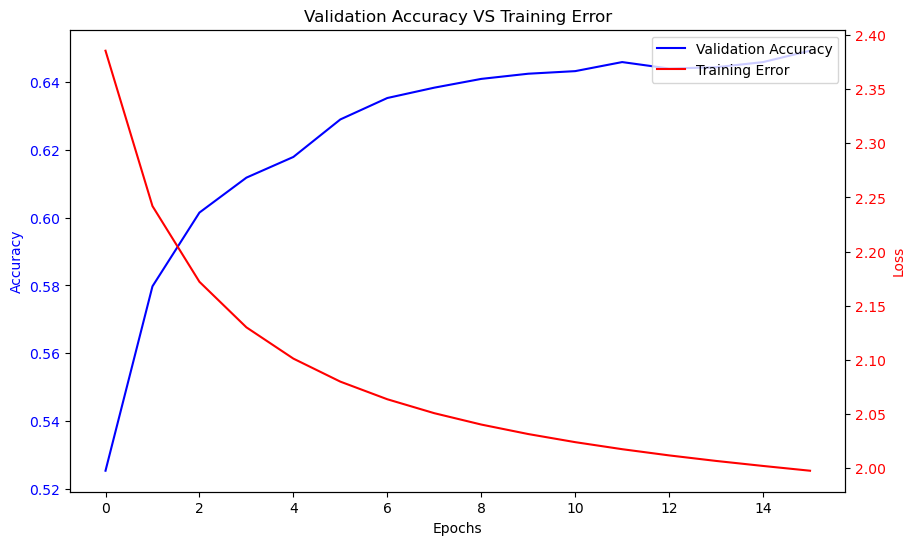

In [317]:


df = pd.read_csv('task_A_stats.csv')

fig, ax1 = plt.subplots()

#plot validation accuracy
ax1.plot(df['epoch'], df['validation_accuracy'], color='blue', label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='blue')
ax1.set_title('Validation Accuracy VS Training Error')
ax1.tick_params(axis='y', labelcolor='blue')

#y-axis for training error
ax2 = ax1.twinx()
ax2.plot(df['epoch'], df['training_error'], color='red', label='Training Error')
ax2.set_ylabel('Loss', color='red')
ax2.tick_params(axis='y', labelcolor='red')

#legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()


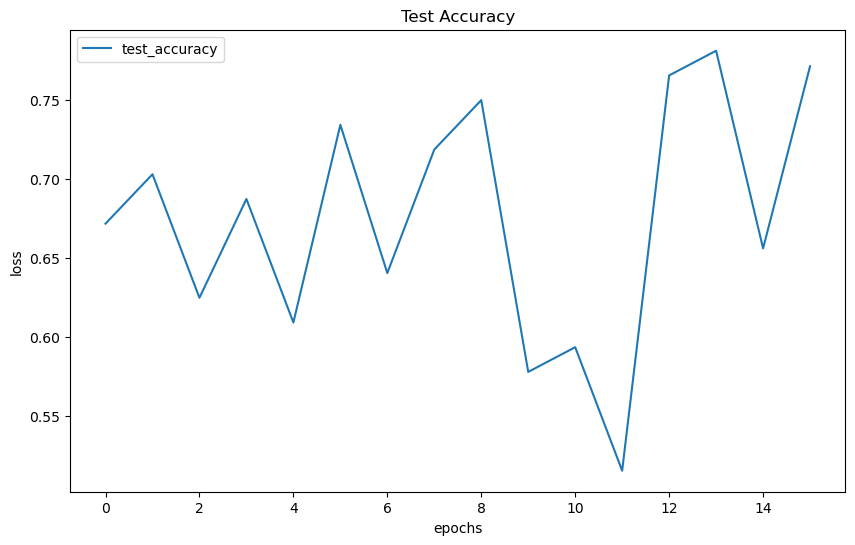

In [318]:

df = pd.read_csv('task_A_test_accuracy.csv')
df[['epoch', 'test_accuracy']].plot(
    x='epoch',
    xlabel='epochs',
    ylabel='loss',
    title='Test Accuracy',
)
_=plt.show()

In [273]:
# TABLE WITH RESULTS
stats_df = pd.read_csv('TASK_A_stats.csv')
test_accuracy_df = pd.read_csv('TASK_A_test_accuracy.csv')
merged_df = pd.merge(stats_df, test_accuracy_df, on='epoch')
result_df = merged_df[['epoch', 'validation_accuracy', 'test_accuracy']]
result_df.to_csv('TASK_A_results_table.csv', index=False)
result_df = result_df.set_index('epoch')
result_df


,validation_accuracy,test_accuracy
epoch,,
0.0,0.525407,0.671875
1.0,0.579734,0.703125
2.0,0.601457,0.625000
3.0,0.611746,0.687500
4.0,0.617844,0.609375
5.0,0.628896,0.734375
6.0,0.635205,0.640625
7.0,0.638254,0.718750
8.0,0.640837,0.750000


<a name="section-classification-rnn"></a><h2 style="color:rgb(0,120,170)">Classification with LSTM </h2>

<div>

 `ClassificationRNNModel` extends `ClassificationAverageModel` by an LSTM layer. 

 **Three variations** of the baseline LSTM model have been implemented, for a better understanding of the effects of hyperparameters & different architecture choices:

- **Variation 1 - Word Embeddings & RNN.** 
  - Freeze the weights of encoder word embeddings (no updates)
  - Initialize the encoder word embeddings randomly instead of using pretrained embeddings. 
  - Increase/decrease the dimension of the hidden state of the RNN.
  - Use GRU instead of LSTM.
<br>
- **Variation 2 - Regularization & Optimization.** 
  - Increase/decrease drop out rates and tune the model accordingly.
  - Add L2 weight regularization to the loss function.
  - Use SGD instead of Adam.
<br>
- **Variation 3 - Document Embedding .** 
  - Use a Bidirectional LSTM, and set the document embedding as the concatenation of the last state of forward LSTM with the last state of backward LSTM.
  


</div>

In [30]:
n_labels = 12
class ClassificationRNNModel(ClassificationAverageModel):
    def __init__(self, embedding, n_labels, hidden_size=300, num_layers=1, dropout=0.05,
                 freeze_embeddings=False, use_gru=False, bidirectional=False, mean_pooling=False, pretrained=True,
                 learning_rate = 0.001, fill_token= "#fill#", min_word_frequency= 5):
        super().__init__(embedding, n_labels)
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.mean_pooling = mean_pooling
        self.freeze_embeddings = freeze_embeddings
        self.dropout = dropout
        
        if pretrained:
            extra_embeddings = torch.randn(1, embedding.embedding_dim)
            extended_embeddings = torch.cat((embedding.weight, extra_embeddings), 0)
        
            self.embedding = nn.Embedding.from_pretrained(extended_embeddings, freeze=self.freeze_embeddings)
        else:
            self.embedding = nn.Embedding(num_embeddings = embedding.num_embeddings + 1, 
                                      embedding_dim = embedding.embedding_dim) 
            
        self.embedding.weight.requires_grad = not freeze_embeddings
        
        rnn_module = torch.nn.GRU if use_gru else torch.nn.LSTM 
        self.lstm = rnn_module(
            input_size=embedding.embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=bidirectional
        )
        
        self.linear = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), n_labels)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, x, document_lengths):
        
        x = self.embedding(x)

        # use lsmt or gru if specified above
        x, _ = self.lstm(x)

        if self.mean_pooling:
            x = torch.mean(x, dim=1)
        elif self.bidirectional:
            #concatenate the last state from forward and backward lstm
            x = torch.cat((x[:, -1, :self.hidden_size], x[:, 0, self.hidden_size:]), dim=-1)
        else:
            x = x[:, -1, :]

        #Apply dropout layer
        x = torch.nn.functional.dropout(x, p=self.dropout)

        #Linear projection
        x = self.linear(x)
        
        #Softmax
        x = self.softmax(x)

        return x


In [31]:
class M(Dataset):
    def __init__(self, dataset, max_doc_l, BoW):
        super().__init__()
        self.dataset = dataset
        self.max_doc_l = max_doc_l
        self.BoW = list(BoW)
        self.pad_idx = len(self.BoW)  # assuming padding index is the length of BoW

    def __getitem__(self, item):
        ret_val = np.full(self.max_doc_l, self.pad_idx)  # fill with padding index
        i = 0

        for word in self.dataset["raw_words"][item]:
            if i >= self.max_doc_l:
                break
            if word in self.BoW:
                ret_val[i] = self.BoW.index(word)
                i += 1
           

        return torch.from_numpy(ret_val).type(torch.IntTensor), self.dataset["label"][item], i  # return length

    def __len__(self):
        return len(self.dataset)

def evaluate(val_dataloader, model):
    device = next(model.parameters()).device
    accuracy = []

    for x, y, lengths in val_dataloader:
        non_empty_indices = lengths.nonzero().squeeze()  # Get indices of non-empty sequences
        if non_empty_indices.numel() == 0:
            continue  # Skip empty sequences

        x = x[non_empty_indices]
        y = y[non_empty_indices]
        lengths = lengths[non_empty_indices]

        x, y, lengths = x.to(device), y.to(device), lengths.to(device)  # Move to GPU if available

        y_pred = model.forward(x, lengths)  # Pass lengths to forward function
        y_pred = torch.argmax(y_pred, dim=1)
        accuracy_ = torch.mean((y == y_pred).float())

        accuracy.append(accuracy_)

    return accuracy

#@torch.enable_grad()
def update(dataloader, model, loss, optimizer): 
    device = next(model.parameters()).device
    err = []
    model.train()

    for x, y, lengths in dataloader:
        
        #if x.min() != 0:
         #   x = x - 1
            
        #print(" x max", x.max(), "x min", x.min())
        x, y = x.to(device), y.to(device) #gpu

        optimizer.zero_grad()
        
        y_pred = model.forward(x, lengths)
        
        loss_ = loss(y_pred, y) 
        
        err.append(loss_)
        
        loss_.backward()
        
        optimizer.step() 
        
    return err, model


In [32]:
def pad_collate_fn(batch):
    (xx, yy, ll) = zip(*batch)
    
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=train_p.pad_idx)  # pad sequence with padding index
    yy_tensor = torch.tensor(yy, dtype=torch.long)
    ll_tensor = torch.tensor(ll, dtype=torch.long)
    
    return xx_pad, yy_tensor, ll_tensor


In [33]:
batch_size = 32
max_doc_l = 50

#----------------------------

train_p = M(datasets["train"]["df"], max_doc_l=max_doc_l, BoW=words)
train_loader = DataLoader(train_p, batch_size=batch_size, collate_fn=pad_collate_fn) 

val_p = M(datasets["validation"]["df"], max_doc_l=max_doc_l, BoW=words)
val_loader = DataLoader(val_p, batch_size=batch_size, collate_fn=pad_collate_fn)  

test_p = M(datasets["test"]["df"], max_doc_l=max_doc_l, BoW=words)
test_loader = DataLoader(test_p, batch_size=batch_size, collate_fn=pad_collate_fn)  


In [50]:
variations = [
    {
        "name": "Baseline", 
        "parameters": {"use_gru": False, "bidirectional": False, "mean_pooling": False, "freeze_embeddings": False},
        "optimizer": "Adam",
        "weight_decay": 0,  
     },
    {
        "name": "Variation1",
        "parameters": { "use_gru": True, "bidirectional": False, "mean_pooling": False, "freeze_embeddings": True, "pretrained":True, "hidden_size":50},
        "optimizer": "Adam",
        "weight_decay": 0,
    },
    {
       "name": "Variation2",
       "parameters": { "use_gru": False, "bidirectional": False, "mean_pooling": False, "freeze_embeddings": False},
       "optimizer": "SGD",
       "weight_decay": 0,  
    },
    {
        "name": "Variation3",
        "parameters": {"use_gru": False, "bidirectional": True, "mean_pooling": True, "freeze_embeddings": False},
        "optimizer": "Adam",
        "weight_decay": 0,
    }
 ]

In [ ]:
torch.manual_seed(42)
epochs = 100
early_stopping = 10
lr=0.01

results = {}

for variation in variations:
    print(f"\nTraining model: {variation['name']}")

    model = ClassificationRNNModel(embedding, n_label, **variation['parameters'])

    if variation['optimizer'] == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=variation['weight_decay'])
    elif variation['optimizer'] == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=variation['weight_decay'])

    loss = torch.nn.CrossEntropyLoss()
    best_mean = 0.0
    last_accuracy = 0
    early_stopping_counter = early_stopping
    stats = pd.DataFrame(columns=["epoch", "training_error", "validation_accuracy"])
    start = time.time()

    for epoch in tqdm(range(epochs)):
        train_err, model = update(train_loader, model, loss, optimizer)  
        train_err = ([x.tolist() for x in train_err])
        train_err = np.mean(train_err)
        accuracy = evaluate(val_loader, model)
        accuracy = ([x.tolist() for x in accuracy])
        accuracy = np.mean(accuracy)
        print("accuracy", accuracy)

        if epoch % 10 == 0:
            end2 = time.time()
            print(f"epoch n: {epoch}  accuracy: {accuracy} training_error: {train_err} in {end2-start} seconds")

        stats.loc[len(stats)] = [epoch,train_err,accuracy]

        if accuracy > best_mean:
            best_mean = accuracy
            torch.save(model.state_dict(), f"TaskB_{variation['name']}_best_model.pkl") 
        else: #early stopping
            if np.isclose(last_accuracy, accuracy, rtol = 1e-02) or accuracy < last_accuracy:
                if early_stopping_counter == 0:
                    break
                else:
                    early_stopping_counter -= 1
            else:
                pass
#                 early_stopping_counter = early_stopping
#              print(early_stopping_counter)

        last_accuracy = accuracy

    end = time.time()  
    print(f"Training time for {variation['name']}: {end-start} seconds")
    stats.to_csv(f"TaskB_{variation['name']}_stats.csv", index= False)

    results[variation['name']] = stats

In [ ]:
for variation in variations:
    model = torch.load(f"{variation['name']}_best_model.pkl")
    model.eval()
    
    all_test_accuracy = evaluate(test_loader, model)
    accuracy_list = [x.tolist() for x in all_test_accuracy]
    accuracy_mean = np.mean(accuracy_list)

#     Save accuracy as .csv
    with open(f'taskB_{variation["name"]}_test_accuracy.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['epoch', 'test_accuracy'])
        for epoch, accuracy in enumerate(accuracy_list[:30], start=0):
            writer.writerow([epoch, accuracy])

    print(f"{variation['name']} - Test accuracy: {accuracy_mean * 100} %")

In [73]:
#RESULTS TABLE
df1_train = pd.read_csv('TaskB_Baseline_stats.csv')
df1_test = pd.read_csv('taskB_Baseline_test_accuracy.csv')
df2_train = pd.read_csv('TaskB_Variation1_stats.csv')
df2_test = pd.read_csv('taskB_Variation1_test_accuracy.csv')
df3_train = pd.read_csv('TaskB_Variation2_stats.csv')
df3_test = pd.read_csv('taskB_Variation2_test_accuracy.csv')
df4_train = pd.read_csv('TaskB_Variation3_stats.csv')
df4_test = pd.read_csv('taskB_Variation3_test_accuracy.csv')

df1 = pd.merge(df1_train, df1_test, on='epoch')
df2 = pd.merge(df2_train, df2_test, on='epoch')
df3 = pd.merge(df3_train, df3_test, on='epoch')
df4 = pd.merge(df4_train, df4_test, on='epoch')


table = pd.DataFrame({
    'Epoch': df1['epoch'],
    'Validation Accuracy (Baseline)': df1['validation_accuracy'],
    'Test Accuracy (Baseline)': df1['test_accuracy'],
    'Validation Accuracy (Variation 1)': df2['validation_accuracy'],
    'Test Accuracy (Variation 1)': df2['test_accuracy'],
    'Validation Accuracy (Variation 2)': df3['validation_accuracy'],
    'Test Accuracy (Variation 2)': df3['test_accuracy'],
        'Validation Accuracy (Variation 3)': df4['validation_accuracy'],
    'Test Accuracy (Variation 3)': df4['test_accuracy']
})

table = table.sort_values('Epoch')
table = table.reset_index(drop=True)
table.to_csv('TaskB_LSTM_result_table.csv', index=False)
table.reset_index(inplace=True)  
table['Epoch'] = range(0, len(table))  
table.set_index('Epoch', inplace=True)  
table


,index,Validation Accuracy (Baseline),Test Accuracy (Baseline),Validation Accuracy (Variation 1),Test Accuracy (Variation 1),Validation Accuracy (Variation 2),Test Accuracy (Variation 2),Validation Accuracy (Variation 3),Test Accuracy (Variation 3)
Epoch,,,,,,,,,
0,0,0.624238,0.71875,0.615854,0.656250,0.251143,0.53125,0.753811,0.71875
1,1,0.664634,0.56250,0.628811,0.718750,0.262576,0.46875,0.742759,0.84375
2,2,0.667683,0.75000,0.637957,0.755000,0.266006,0.65625,0.750000,0.78125
3,3,0.665777,0.65625,0.633384,0.593750,0.267149,0.59375,0.741997,0.78125
4,4,0.662729,0.56250,0.643674,0.843750,0.270579,0.50000,0.731326,0.68750
5,5,0.675305,0.81250,0.648247,0.750000,0.270579,0.50000,0.733613,0.81250
6,6,0.665396,0.90625,0.642149,0.687500,0.273247,0.78125,0.728659,0.87500
7,7,0.663491,0.65625,0.641006,0.550000,0.278963,0.53125,0.727896,0.65625
8,8,0.678735,0.71875,0.645198,0.531250,0.273247,0.56250,0.715701,0.71875


In [78]:
mean_table = table.mean().to_frame().T
mean_table

,Epoch,Validation Accuracy (Baseline),Test Accuracy (Baseline),Validation Accuracy (Variation 1),Test Accuracy (Variation 1),Validation Accuracy (Variation 2),Test Accuracy (Variation 2),Validation Accuracy (Variation 3),Test Accuracy (Variation 3)
0,8.5,0.659786,0.696181,0.64235,0.657882,0.347154,0.555208,0.732311,0.757812


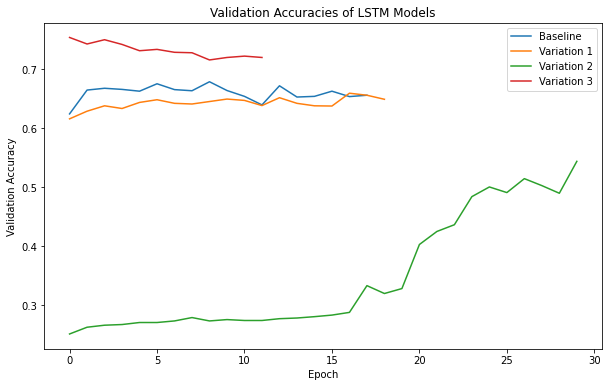

In [84]:
table = pd.read_csv('TaskB_LSTM_result_table.csv')
table['Epoch'] = range(0, len(table))  

plt.figure(figsize=(10, 6))
plt.plot(table['Epoch'], table['Validation Accuracy (Baseline)'], label='Baseline')
plt.plot(table['Epoch'], table['Validation Accuracy (Variation 1)'], label='Variation 1')
plt.plot(table['Epoch'], table['Validation Accuracy (Variation 2)'], label='Variation 2')
plt.plot(table['Epoch'], table['Validation Accuracy (Variation 3)'], label='Variation 3')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracies of LSTM Models')
plt.legend()

plt.show()


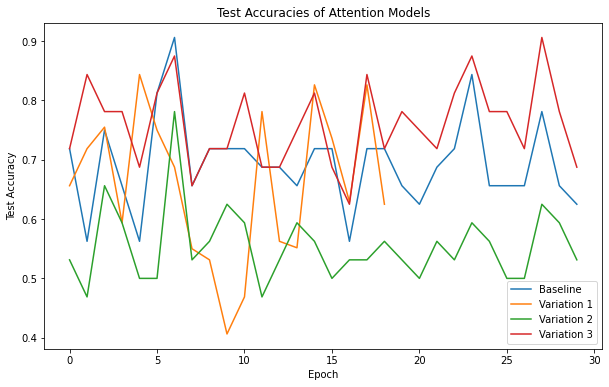

In [77]:
df1 = pd.read_csv('taskB_Baseline_test_accuracy.csv')
df2 = pd.read_csv('taskB_Variation1_test_accuracy.csv')
df3 = pd.read_csv('taskB_Variation2_test_accuracy.csv')
df4 = pd.read_csv('taskB_Variation3_test_accuracy.csv')

test_accuracy1 = df1['test_accuracy']
test_accuracy2 = df2['test_accuracy']
test_accuracy3 = df3['test_accuracy']
test_accuracy4 = df4['test_accuracy']

max_length = max(len(test_accuracy1), len(test_accuracy2), len(test_accuracy3), len(test_accuracy4))

x = range(max_length)

plt.plot(x[:len(test_accuracy1)], test_accuracy1, label='Baseline')
plt.plot(x[:len(test_accuracy2)], test_accuracy2, label='Variation 1')
plt.plot(x[:len(test_accuracy3)], test_accuracy3, label='Variation 2')
plt.plot(x[:len(test_accuracy4)], test_accuracy4, label='Variation 3')

plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracies of Attention Models')
plt.legend()

plt.show()                         

<a name="section-classification-attention"></a><h2 style="color:rgb(0,120,170)">Document Classification with Attention</h2>


**`ClassificationAttentionModel`** based on the paper.


In [276]:
#embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(dict_vals))

In [284]:

class Attention(nn.Module):
    def __init__(self, size = embedding.embedding_dim):
        super(Attention, self).__init__()
        self.query = nn.Parameter(torch.randn(1, size)) 

    def forward(self, values, mask):
        batch_size = values.size(0)
        query = self.query.expand(batch_size, -1).unsqueeze(dim=1)  #torch.Size([64, 1, 50]) except last
        scores = torch.bmm(query, values.transpose(1, 2))           #scores torch.Size([64, 1, 50])
        scores = scores.squeeze(dim=1)                              #scores torch.Size([64, 50])   
        scores.masked_fill_(mask == 0, -1e26)
        weights = F.softmax(scores, dim=-1)                         #torch.Size([64, 50])
        weights = weights.unsqueeze(dim=1)                          #torch.Size([64, 1, 50])
        res = torch.bmm(weights, values)                            #torch.Size([64, 1, 50])
        res = res.squeeze(dim=1)                                    #torch.Size([64, 50])
        return res
    
class MultiplicativeAttention(nn.Module):
    def __init__(self, size = embedding.embedding_dim):
        super(MultiplicativeAttention, self).__init__()
        self.query = nn.Parameter(torch.randn(1, size)) 
        self.W = nn.Parameter(torch.randn(size, size)) 

    def forward(self, values, mask):
        batch_size = values.size(0)
        query = self.query.expand(batch_size, -1).unsqueeze(dim=1) 
        scores = torch.matmul(query, torch.matmul(values, self.W).transpose(1, 2))
        scores = scores.squeeze(dim=1)
        scores.masked_fill_(mask == 0, -1e26)
        weights = F.softmax(scores, dim=-1)                         #torch.Size([64, 50])
        weights = weights.unsqueeze(dim=1)                          #torch.Size([64, 1, 50])
        res = torch.bmm(weights, values)                            #torch.Size([64, 1, 50])
        res = res.squeeze(dim=1)                                    #torch.Size([64, 50])
        return res
    
   

class ClassificationAttentionModel(nn.Module):
    def __init__(self, embedding, hidden_size=25, n_labels=n_label, embed_dim=embedding.embedding_dim, use_rnn=True, attention_type='dot'):
        super(ClassificationAttentionModel, self).__init__()

        self.use_rnn = use_rnn
        self.attention_type = attention_type

        self.embedding = torch.nn.Embedding(num_embeddings = embedding.num_embeddings + 1, embedding_dim = embedding.embedding_dim ) 
        #rnn
        if self.use_rnn:
            
            self.rnn = nn.GRU(input_size=embed_dim, 
                              hidden_size=hidden_size,
                              num_layers=1,
                              batch_first=True,
                              dropout=0,
                              bidirectional=True)
        
        #attention                                
            self.attention = Attention(2*hidden_size) if attention_type == 'dot' else MultiplicativeAttention(2*hidden_size)
        else:
            self.attention = Attention(embed_dim) if attention_type == 'dot' else MultiplicativeAttention(embed_dim)
        
        #linear layer
        self.fc = nn.Linear(2*hidden_size if self.use_rnn else embed_dim, n_labels)

    def forward(self, x):
        
        x = self.embedding(x)

        if self.use_rnn:
            output, _ = self.rnn(x)
        else:
            output = x
        
        mask = (x != 0)                 #exclude padding tokens
        mask = torch.any(mask, dim=-1)  #reshape mask

        attention_output = self.attention(output,mask) 
        
        logits = self.fc(attention_output)
        
        return F.log_softmax(logits, dim=-1)


In [285]:

class M(Dataset):
    def __init__(self, dataset, max_doc_l, BoW):
        super().__init__()
        self.dataset = dataset
        self.max_doc_l = max_doc_l
        self.BoW = list(BoW)
        self.pad_idx = len(self.BoW)  # assuming padding index is the length of BoW

    def __getitem__(self, item):
        ret_val = np.full(self.max_doc_l, self.pad_idx)  # fill with padding index
        i = 0

        for word in self.dataset["raw_words"][item]:
            if i >= self.max_doc_l:
                break
            if word in self.BoW:
                ret_val[i] = self.BoW.index(word)
                i += 1
           

        return torch.from_numpy(ret_val).type(torch.IntTensor), self.dataset["label"][item], i  # return length

    def __len__(self):
        return len(self.dataset)

def evaluate(val_dataloader, model):
    device = next(model.parameters()).device
    accuracy = []

    for x, y, lengths in val_dataloader:
        non_empty_indices = lengths.nonzero().squeeze()  # Get indices of non-empty sequences
        if non_empty_indices.numel() == 0:
            continue  # Skip empty sequences

        x = x[non_empty_indices]
        y = y[non_empty_indices]
        lengths = lengths[non_empty_indices]

        x, y, lengths = x.to(device), y.to(device), lengths.to(device)  # Move to GPU if available

        y_pred = model.forward(x)  
        y_pred = torch.argmax(y_pred, dim=1)
        accuracy_ = torch.mean((y == y_pred).float())

        accuracy.append(accuracy_)

    return accuracy

#@torch.enable_grad()
def update(dataloader, model, loss, optimizer): 
    device = next(model.parameters()).device
    err = []
    model.train()

    for x, y, lengths in dataloader:
        
        x, y = x.to(device), y.to(device) #gpu
       
        optimizer.zero_grad()
        
        y_pred = model.forward(x)
        
        loss_ = loss(y_pred, y) 
        
        err.append(loss_)
        
        loss_.backward()
        
        optimizer.step() 
        
    return err, model


In [286]:
variations = [
    {
        "name": "Baseline", 
        "parameters": {  "use_rnn": True, "attention_type": 'dot'},
        "optimizer": "Adam",
        "weight_decay": 0, 
    },
    {
        "name": "Variation1",
        "parameters": { "use_rnn": False, "attention_type": 'dot'},
        "optimizer": "Adam",
        "weight_decay": 0,
    },
    {
        "name": "Variation2",
        "parameters": { "use_rnn": True, "attention_type": None}, # multiplicative attention
        "optimizer": "Adam",
        "weight_decay": 0,
    }
]

In [ ]:
from tqdm import tqdm
torch.manual_seed(42)
lr = 0.001
epochs = 20
early_stopping = 5


results = {}

for variation in variations:
    print(f"\nTraining model: {variation['name']}")

    model = ClassificationAttentionModel(embedding=embedding, **variation['parameters'])

    if variation['optimizer'] == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=variation['weight_decay'])
    elif variation['optimizer'] == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=variation['weight_decay'])

    loss = torch.nn.CrossEntropyLoss()
    best_mean = 0
    last_accuracy = 0
    early_stopping_counter = early_stopping
    stats = pd.DataFrame(columns=["epoch", "training_error", "validation_accuracy"])
    start = time.time()
   
    for epoch in tqdm(range(epochs)):
       
        train_err, _ = update(train_loader, model, loss, optimizer)  # No need to pass l_tensor here
        train_err = ([x.tolist() for x in train_err])
        train_err = np.mean(train_err)
        accuracy = evaluate(val_loader, model)
        accuracy = ([x.tolist() for x in accuracy])
        accuracy = np.mean(accuracy)
        
       
        if epoch % 9 == 0:
            end2 = time.time()
            print(f"epoch n: {epoch}  accuracy: {accuracy} training_error: {train_err} in {end2-start} seconds")

        stats.loc[len(stats)] = [epoch,train_err,accuracy]

        if accuracy > best_mean: 
            best_mean = accuracy
            
            
            torch.save(model.state_dict(), f"TASK_C_{variation['name']}_best_model.pkl") 
        else:                                       #early stopping   
            if np.isclose(last_accuracy, accuracy, rtol=1e-02):
                if early_stopping_counter == 0:
                    break
                else:
                    early_stopping_counter -= 1
            else:
                early_stopping_counter = early_stopping

        last_accuracy = accuracy

    end = time.time()  
    print(f"Training time for {variation['name']}: {end-start} seconds")
    stats.to_csv(f"TASK_C_{variation['name']}_stats.csv", index= False)

    results[variation['name']] = stats


In [293]:
for variation in variations:
    model = ClassificationAttentionModel(embedding=embedding, **variation["parameters"])
    model.load_state_dict(torch.load(f"TASK_B_{variation['name']}_best_model.pkl"))
    model.eval()

    all_test_accuracy = evaluate(test_loader, model)
    accuracy_list = [x.tolist() for x in all_test_accuracy]
    accuracy_mean = np.mean(accuracy_list)

    # Save accuracy as .csv
    with open(f'task_B_{variation["name"]}_test_accuracy.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['epoch', 'test_accuracy'])
        for epoch, accuracy in enumerate(accuracy_list, start=0):
            writer.writerow([epoch, accuracy])

    print(f"{variation['name']} - Test accuracy: {accuracy_mean * 100} %")

Baseline - Test accuracy: 68.22505331620937 %
Variation1 - Test accuracy: 58.162141936581314 %
Variation2 - Test accuracy: 68.13867121208006 %


In [308]:
#RESULTS TABLE
df1_train = pd.read_csv('TASK_B_Baseline_stats.csv')
df1_test = pd.read_csv('task_B_Baseline_test_accuracy.csv')
df2_train = pd.read_csv('TASK_B_Variation1_stats.csv')
df2_test = pd.read_csv('task_B_Variation1_test_accuracy.csv')
df3_train = pd.read_csv('TASK_B_Variation2_stats.csv')
df3_test = pd.read_csv('task_B_Variation2_test_accuracy.csv')

df1 = pd.merge(df1_train, df1_test, on='epoch')
df2 = pd.merge(df2_train, df2_test, on='epoch')
df3 = pd.merge(df3_train, df3_test, on='epoch')

table = pd.DataFrame({
    'Epoch': df1['epoch'],
    'Validation Accuracy (Baseline)': df1['validation_accuracy'],
    'Test Accuracy (Baseline)': df1['test_accuracy'],
    'Validation Accuracy (Variation 1)': df2['validation_accuracy'],
    'Test Accuracy (Variation 1)': df2['test_accuracy'],
    'Validation Accuracy (Variation 2)': df3['validation_accuracy'],
    'Test Accuracy (Variation 2)': df3['test_accuracy']
})

table = table.sort_values('Epoch')
table = table.reset_index(drop=True)
table.to_csv('TASK_B_ATTENTION_result_table.csv', index=False)
table = table.set_index('Epoch')
table


,Validation Accuracy (Baseline),Test Accuracy (Baseline),Validation Accuracy (Variation 1),Test Accuracy (Variation 1),Validation Accuracy (Variation 2),Test Accuracy (Variation 2)
Epoch,,,,,,
0.0,0.493606,0.640625,0.475398,0.671875,0.381690,0.715625
1.0,0.614541,0.703125,0.517065,0.656250,0.572790,0.734375
2.0,0.648670,0.687500,0.543953,0.468750,0.604717,0.680625
3.0,0.663152,0.718750,0.548315,0.609375,0.624534,0.730000
4.0,0.674500,0.656250,0.545816,0.500000,0.641303,0.687500
5.0,0.674204,0.796875,0.547341,0.515625,0.665608,0.671875
6.0,0.678777,0.734375,0.553269,0.625000,0.667937,0.656250
7.0,0.677168,0.609375,0.562627,0.610625,0.670308,0.655000
8.0,0.683181,0.578125,0.567666,0.546875,0.664295,0.703125


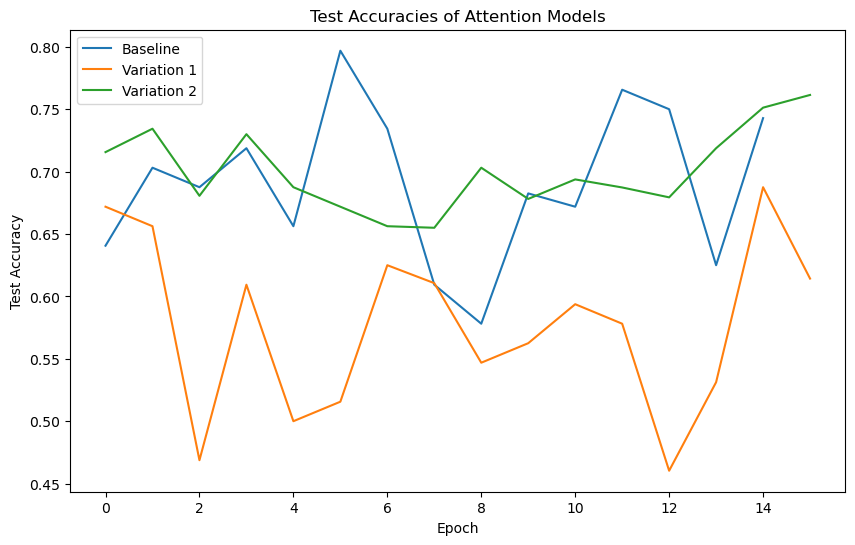

In [319]:
df1 = pd.read_csv('task_B_Baseline_test_accuracy.csv')
df2 = pd.read_csv('task_B_Variation1_test_accuracy.csv')
df3 = pd.read_csv('task_B_Variation2_test_accuracy.csv')

test_accuracy1 = df1['test_accuracy']
test_accuracy2 = df2['test_accuracy']
test_accuracy3 = df3['test_accuracy']

max_length = max(len(test_accuracy1), len(test_accuracy2), len(test_accuracy3))

x = range(max_length)

plt.plot(x[:len(test_accuracy1)], test_accuracy1, label='Baseline')
plt.plot(x[:len(test_accuracy2)], test_accuracy2, label='Variation 1')
plt.plot(x[:len(test_accuracy3)], test_accuracy3, label='Variation 2')

plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracies of Attention Models')
plt.legend()

plt.show()                          

Both the Baseline with dot product attention and the second variation with multiplicative attention show similar performances in terms of accuracy, but the second one, having an additional matrix of parameters (`self.W`) has a slower but smoother learning curve, whereas basic dot product suffers from spikes, as we see in the plot. The first Variation, lacking of the bidirectional GRU layer yields worse performance overall.

<a name="section-classification-transformer"></a><h2 style="color:rgb(0,120,170)">Document Classification with Transformer</h2>


The implementation of the basic architecture of `ClassificationTransformerModel` has also been extended with variations:


- **Transformer Encoder.** Replace the RNN layer with a Transformer Encoder. Similar to the RNN, the aim of this layer is to provide contextual embeddings of the input word embeddings. 

- **Number of heads.** To study the effect of increasing/decreasing the number of heads of the Transformer Decoder.

- **Number of layers.** To study the effect of increasing the layers of the Transformer Decoder.



</div>

In [375]:
class ClassificationTransformerModel(nn.Module):
    def __init__(self, embedding, hidden_size=150, n_labels=n_label, embed_dim=embedding.embedding_dim, nhead=3, n_layers=1, use_rnn=True):
        super(ClassificationTransformerModel, self).__init__()

        self.use_rnn = use_rnn
        self.embedding = torch.nn.Embedding(num_embeddings=embedding.num_embeddings + 1, embedding_dim=embedding.embedding_dim)
        
        if self.use_rnn:
            self.rnn = nn.GRU(input_size=embed_dim,
                              hidden_size=hidden_size,
                              num_layers=1,
                              batch_first=True,
                              dropout=0,
                              bidirectional=True)
        else: 
            #encoder
            encoder_layer=nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
            self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        #decoder (for both)
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_layers)
        
        #linear layer
        self.fc = nn.Linear(2 * hidden_size if self.use_rnn else embed_dim, n_labels)

    def forward(self, x):
        x = self.embedding(x)
       
        if self.use_rnn: #GRU
            x, _ = self.rnn(x)
            
        else: #encoder
            x = self.encoder(x)
            

        self.query = nn.Parameter(torch.randn(x.size(0), 1 , x.size(2)))
        
        x = self.decoder(self.query, x)
        
        x = self.fc(x)
        x = x.reshape(x.size(0), -1)
        
        return F.log_softmax(x, dim=-1)


In [376]:

class M(Dataset):
    def __init__(self, dataset, max_doc_l, BoW):
        super().__init__()
        self.dataset = dataset
        self.max_doc_l = max_doc_l
        self.BoW = list(BoW)
        self.pad_idx = len(self.BoW)  # assuming padding index is the length of BoW

    def __getitem__(self, item):
        ret_val = np.full(self.max_doc_l, self.pad_idx)  # fill with padding index
        i = 0

        for word in self.dataset["raw_words"][item]:
            if i >= self.max_doc_l:
                break
            if word in self.BoW:
                ret_val[i] = self.BoW.index(word)
                i += 1
           

        return torch.from_numpy(ret_val).type(torch.IntTensor), self.dataset["label"][item], i  # return length

    def __len__(self):
        return len(self.dataset)

def evaluate(val_dataloader, model):
    device = next(model.parameters()).device
    accuracy = []

    for x, y, lengths in val_dataloader:
        non_empty_indices = lengths.nonzero().squeeze()  # Get indices of non-empty sequences
        if non_empty_indices.numel() == 0:
            continue  # Skip empty sequences

        x = x[non_empty_indices]
        y = y[non_empty_indices]
        lengths = lengths[non_empty_indices]

        x, y, lengths = x.to(device), y.to(device), lengths.to(device)  # Move to GPU if available

        y_pred = model.forward(x)  
        y_pred = torch.argmax(y_pred, dim=1)
        accuracy_ = torch.mean((y == y_pred).float())

        accuracy.append(accuracy_)

    return accuracy

#@torch.enable_grad()
def update(dataloader, model, loss, optimizer): 
    device = next(model.parameters()).device
    err = []
    model.train()

    for x, y, lengths in dataloader:
        
        x, y = x.to(device), y.to(device) #gpu
       
        optimizer.zero_grad()
        
        y_pred = model.forward(x)
        
        loss_ = loss(y_pred, y) 
        
        err.append(loss_)
        
        loss_.backward()
        
        optimizer.step() 
        
    return err, model


In [361]:

variations = [
    {
        "name": "Baseline", 
        "parameters": { "use_rnn": True, "nhead": 3, "n_layers": 1}, #GRU 3 heads, 1 layer
        "optimizer": "Adam",
        "weight_decay": 0, 
    },                                                               #different nhead
    {
        "name": "Baseline_var_1_head", 
        "parameters": { "use_rnn": True, "nhead": 1, "n_layers": 1}, 
        "optimizer": "Adam",
        "weight_decay": 0, 
    },
    {
        "name": "Baseline_var_10_head", 
        "parameters": { "use_rnn": True, "nhead": 10, "n_layers": 1}, 
        "optimizer": "Adam",
        "weight_decay": 0, 
    },
     {
        "name": "Baseline_var_25_head", 
        "parameters": { "use_rnn": True, "nhead": 25, "n_layers": 1}, 
        "optimizer": "Adam",
        "weight_decay": 0, 
    },
     {
        "name": "Baseline_var_50_head", 
        "parameters": { "use_rnn": True, "nhead": 50, "n_layers": 1}, 
        "optimizer": "Adam",
        "weight_decay": 0, 
    },
    {                                                                #different n_layers
        "name": "Baseline_var_3_layers", 
        "parameters": { "use_rnn": True, "nhead": 3, "n_layers": 3}, 
        "optimizer": "Adam",
        "weight_decay": 0, 
    },
    {
        "name": "Baseline_var_5_layers", 
        "parameters": { "use_rnn": True, "nhead": 3, "n_layers": 5}, 
        "optimizer": "Adam",
        "weight_decay": 0, 
    },
    
    {
        "name": "Baseline_var_7_layers", 
        "parameters": { "use_rnn": True, "nhead": 3, "n_layers": 7}, 
        "optimizer": "Adam",
        "weight_decay": 0, 
    },
    {
        "name": "Variation1",
        "parameters": { "use_rnn": False, "nhead": 3, "n_layers": 1},   #ENCODER
        "optimizer": "Adam",
        "weight_decay": 0,
    }
]


In [381]:
torch.manual_seed(42)
lr = 0.001
epochs = 20 #or 5 for comparison different nhead/layers hyperparameters
early_stopping = 5


results = {}

for variation in variations:
    print(f"\nTraining model: {variation['name']}")

    model = ClassificationTransformerModel(embedding=embedding, **variation['parameters'])

    if variation['optimizer'] == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=variation['weight_decay'])
    elif variation['optimizer'] == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=variation['weight_decay'])

    loss = torch.nn.CrossEntropyLoss()
    best_mean = 0
    last_accuracy = 0
    early_stopping_counter = early_stopping
    stats = pd.DataFrame(columns=["epoch", "training_error", "validation_accuracy"])
    start = time.time()
   
    for epoch in tqdm(range(epochs)):
       
        train_err, _ = update(train_loader, model, loss, optimizer)  # No need to pass l_tensor here
        train_err = ([x.tolist() for x in train_err])
        train_err = np.mean(train_err)
        accuracy = evaluate(val_loader, model)
        accuracy = ([x.tolist() for x in accuracy])
        accuracy = np.mean(accuracy)
       
        
       
        if epoch % 9 == 0:
            end2 = time.time()
            print(f"epoch n: {epoch}  accuracy: {accuracy} training_error: {train_err} in {end2-start} seconds")

        stats.loc[len(stats)] = [epoch,train_err,accuracy]

        if accuracy > best_mean: 
            best_mean = accuracy
            
            
            torch.save(model.state_dict(), f"TASK_D_{variation['name']}_best_model.pkl") 
        else: #early stopping   
            if np.isclose(last_accuracy, accuracy, rtol=1e-02):
                if early_stopping_counter == 0:
                    break
                else:
                    early_stopping_counter -= 1
            else:
                early_stopping_counter = early_stopping

        last_accuracy = accuracy

    end = time.time()  
    print(f"Training time for {variation['name']}: {end-start} seconds")
    stats.to_csv(f"TASK_D_{variation['name']}_stats.csv", index= False)

    results[variation['name']] = stats
  



Training model: Variation1


  5%|▌         | 1/20 [04:15<1:21:02, 255.91s/it]

epoch n: 0  accuracy: 0.668656843464549 training_error: 1.5355720651777167 in 255.85003018379211 seconds


 50%|█████     | 10/20 [44:52<44:50, 269.04s/it] 

epoch n: 9  accuracy: 0.724043021841747 training_error: 0.3728303729703552 in 2692.157837152481 seconds


 85%|████████▌ | 17/20 [1:21:02<14:18, 286.04s/it]

Training time for Variation1: 4862.633446931839 seconds


In [363]:
#TEST ACCURACY FOR BASELINE MODEL
model = ClassificationTransformerModel(embedding=embedding, use_rnn=True, nhead=3, n_layers=1)
state_dict = torch.load(f"TASK_D_Baseline_best_model.pkl")
state_dict.pop("query", None)  #remove the "query" key from the state dictionary
model.load_state_dict(state_dict)
model.eval()

all_test_accuracy = evaluate(test_loader, model)  #pass the model instance, not the state dictionary
accuracy_list = [x.tolist() for x in all_test_accuracy]
accuracy_mean = np.mean(accuracy_list)

#save accuracy as .csv
with open('task_D_Baseline_test_accuracy.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['epoch', 'test_accuracy'])
    for epoch, accuracy in enumerate(accuracy_list, start=0):
        writer.writerow([epoch, accuracy])

print(f"Test accuracy: {accuracy_mean * 100} %") #Test accuracy: 75.71186612292034 %

Test accuracy: 75.71186612292034 %


In [383]:
#TEST ACCURACY FOR VARIATION 1 MODEL
model = ClassificationTransformerModel(embedding=embedding, use_rnn=False, nhead=3, n_layers=1)
state_dict = torch.load(f"TASK_D_Variation1_best_model.pkl")
state_dict.pop("query", None)  # Remove the "query" key from the state dictionary
model.load_state_dict(state_dict)
model.eval()

all_test_accuracy = evaluate(test_loader, model)  # Pass the model instance, not the state dictionary
accuracy_list = [x.tolist() for x in all_test_accuracy]
accuracy_mean = np.mean(accuracy_list)

# Save accuracy as .csv
with open('task_D_Variation1_test_accuracy.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['epoch', 'test_accuracy'])
    for epoch, accuracy in enumerate(accuracy_list, start=0):
        writer.writerow([epoch, accuracy])

print(f"Test accuracy: {accuracy_mean * 100} %") #Test accuracy: 74.55550722959565 %

Test accuracy: 74.94434772468195 %


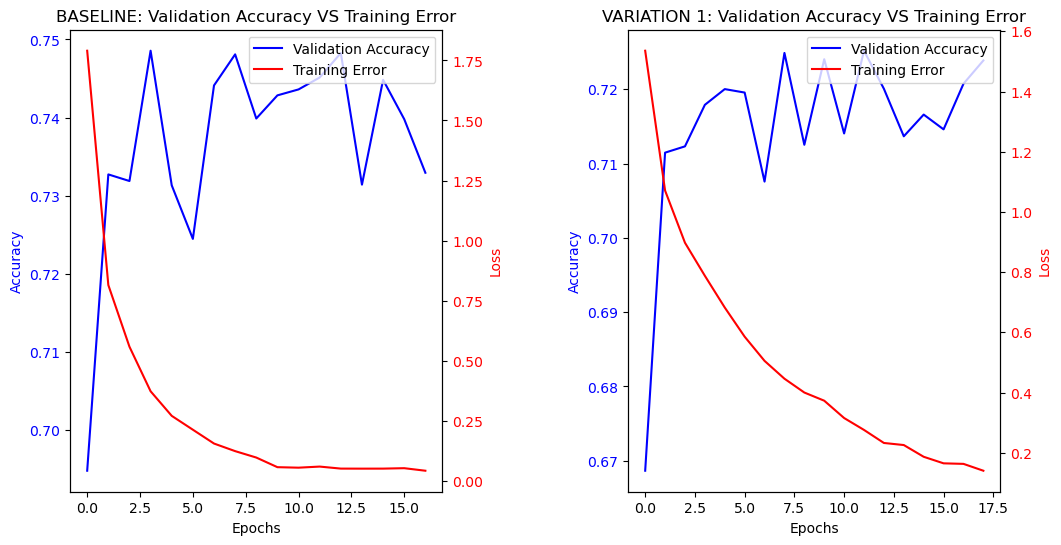

In [388]:
df1 = pd.read_csv('task_D_Baseline_stats.csv')
df2 = pd.read_csv('TASK_D_Variation1_stats.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(df1['epoch'], df1['validation_accuracy'], color='blue', label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='blue')
ax1.set_title('BASELINE: Validation Accuracy VS Training Error')
ax1.tick_params(axis='y', labelcolor='blue')

ax1_2 = ax1.twinx()
ax1_2.plot(df1['epoch'], df1['training_error'], color='red', label='Training Error')
ax1_2.set_ylabel('Loss', color='red')
ax1_2.tick_params(axis='y', labelcolor='red')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_2.get_legend_handles_labels()
ax1_2.legend(lines + lines2, labels + labels2, loc='best')

ax2.plot(df2['epoch'], df2['validation_accuracy'], color='blue', label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy', color='blue')
ax2.set_title('VARIATION 1: Validation Accuracy VS Training Error')
ax2.tick_params(axis='y', labelcolor='blue')

ax2_2 = ax2.twinx()
ax2_2.plot(df2['epoch'], df2['training_error'], color='red', label='Training Error')
ax2_2.set_ylabel('Loss', color='red')
ax2_2.tick_params(axis='y', labelcolor='red')

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_2.get_legend_handles_labels()
ax2_2.legend(lines + lines2, labels + labels2, loc='best')

plt.subplots_adjust(wspace=0.5)
plt.show()


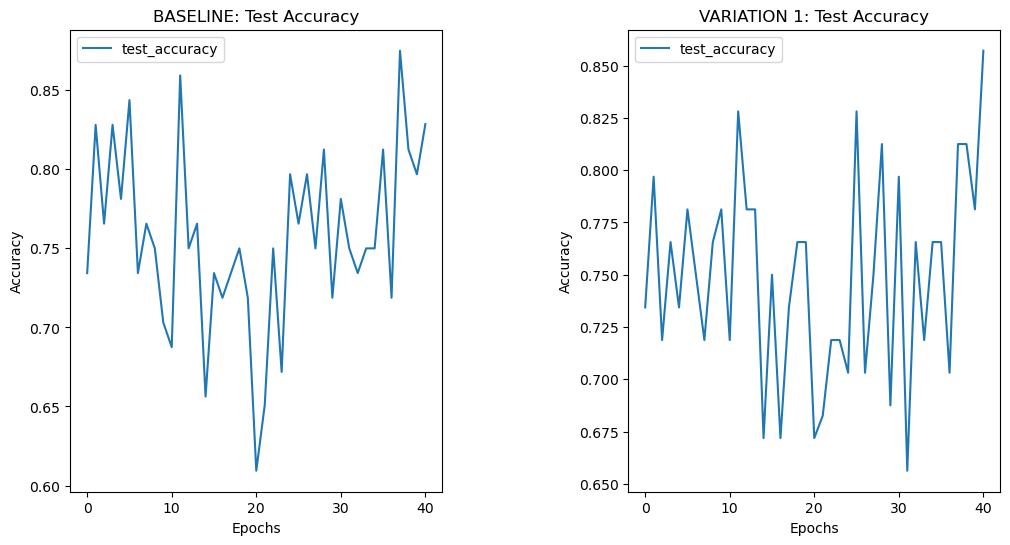

In [390]:
df1 = pd.read_csv('task_D_Baseline_test_accuracy.csv')
df2 = pd.read_csv('task_D_Variation1_test_accuracy.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

df1[['epoch', 'test_accuracy']].plot(
    x='epoch',
    xlabel='Epochs',
    ylabel='Accuracy',
    title='BASELINE: Test Accuracy',
    ax=ax1
)

df2[['epoch', 'test_accuracy']].plot(
    x='epoch',
    xlabel='Epochs',
    ylabel='Accuracy',
    title='VARIATION 1: Test Accuracy',
    ax=ax2
)

plt.subplots_adjust(wspace=0.5)
plt.show()


Due to time, memory and computational limitation, the comparison between different number of heads and layers of the Transformer model has been carried out on 5 epochs (instead of the usual 20).<br><br>
`nhead: 1, 3 (Baseline), 10, 25, 50.` <br>
`n_layers: 1 (Baseline), 3, 5, 7, 10.`<br><br>
First, let's inquire the **test accuracies** of the baseline and the 7 variations:

In [370]:
# Define the list of models
models = [
    ("TASK_D_Baseline_best_model.pkl", {}), #3 heads, 1 layer
    ("TASK_D_Baseline_var_1_head_best_model.pkl", {"nhead": 1}),
    ("TASK_D_Baseline_var_10_head_best_model.pkl", {"nhead": 10}),
    ("TASK_D_Baseline_var_25_head_best_model.pkl", {"nhead": 25}),
    ("TASK_D_Baseline_var_50_head_best_model.pkl", {"nhead": 50}),
    ("TASK_D_Baseline_var_3_layers_best_model.pkl", {"n_layers": 3}),
    ("TASK_D_Baseline_var_5_layers_best_model.pkl", {"n_layers": 5}),
    ("TASK_D_Baseline_var_7_layers_best_model.pkl", {"n_layers": 7})
    
]

# Load and evaluate each model
for model_name, model_params in models:
    model = ClassificationTransformerModel(embedding=embedding, **model_params)
    state_dict = torch.load(model_name)
    state_dict.pop("query", None)  # Remove the "query" key from the state dictionary
    model.load_state_dict(state_dict)
    model.eval()

    all_test_accuracy = evaluate(test_loader, model)
    accuracy_list = [x.tolist() for x in all_test_accuracy]
    accuracy_mean = np.mean(accuracy_list)

    # Extract the model name without the extension
    model_name_without_extension = model_name.split(".")[0]

    # Save accuracy as .csv
    with open(f'{model_name_without_extension}_TEST_ACCURACY.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['epoch', 'test_accuracy'])
        for epoch, accuracy in enumerate(accuracy_list, start=0):
            writer.writerow([epoch, accuracy])

    print(f"{model_name} - Test accuracy: {accuracy_mean * 100} %")


TASK_D_Baseline_best_model.pkl - Test accuracy: 75.41412609379466 %
TASK_D_Baseline_var_1_head_best_model.pkl - Test accuracy: 74.30241006176647 %
TASK_D_Baseline_var_10_head_best_model.pkl - Test accuracy: 74.90744779749615 %
TASK_D_Baseline_var_25_head_best_model.pkl - Test accuracy: 75.0920683872409 %
TASK_D_Baseline_var_50_head_best_model.pkl - Test accuracy: 74.83001845638927 %
TASK_D_Baseline_var_3_layers_best_model.pkl - Test accuracy: 73.21561662162223 %
TASK_D_Baseline_var_5_layers_best_model.pkl - Test accuracy: 24.304224805134098 %
TASK_D_Baseline_var_7_layers_best_model.pkl - Test accuracy: 11.405100691609265 %


In the following the plot for validation accuracy and training error for different values of **heads** are shown:

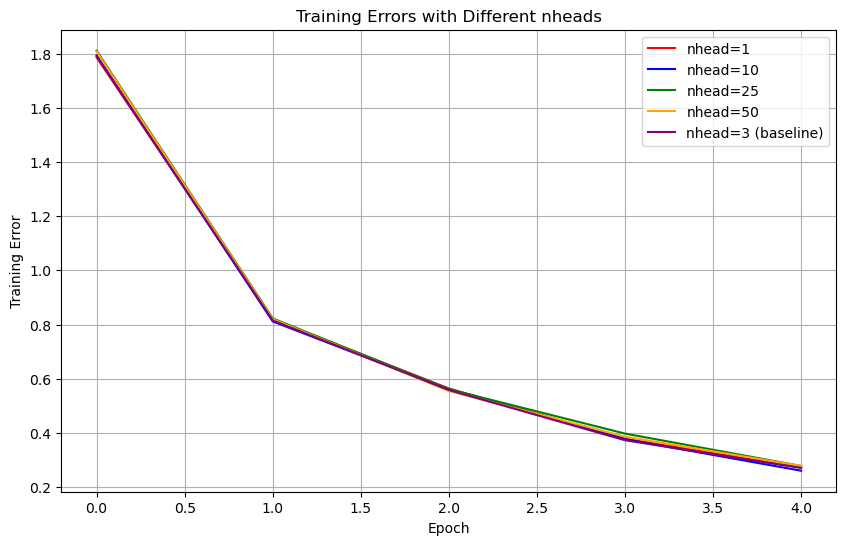

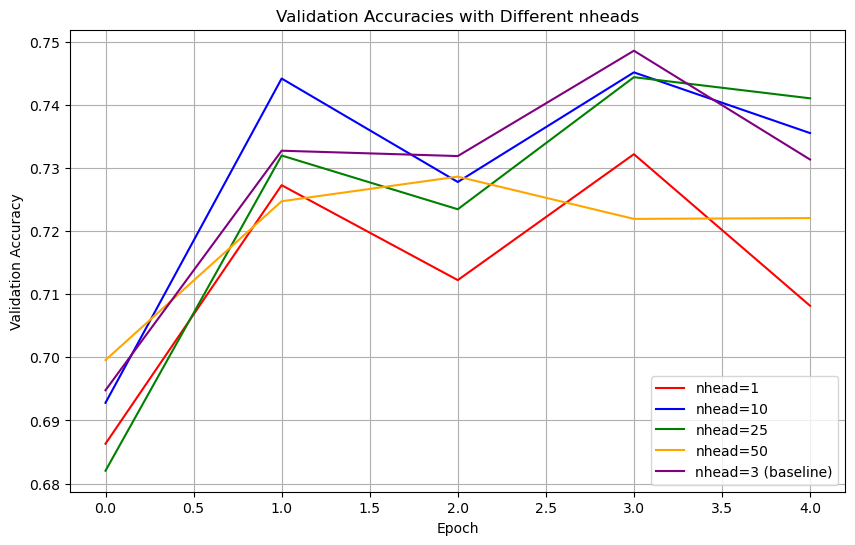

In [339]:
#FOR DIFFERENT NHEADS
csv_files = ['TASK_D_Baseline_var_1_head_stats.csv', 'TASK_D_Baseline_var_10_head_stats.csv', 'TASK_D_Baseline_var_25_head_stats.csv', 'TASK_D_Baseline_var_50_head_stats.csv', 'TASK_D_Baseline_3_heads.csv']
label_names = ['nhead=1', 'nhead=10', 'nhead=25', 'nhead=50', 'nhead=3 (baseline)']
line_colors = ['red', 'blue', 'green', 'orange', 'purple']

epochs = []
training_errors = []
validation_accuracies = []

for file_name in csv_files:
    df = pd.read_csv(file_name)
    epochs.append(df['epoch'].values)
    training_errors.append(df['training_error'].values)
    validation_accuracies.append(df['validation_accuracy'].values)

#plot training errors
for i in range(len(csv_files)):
    plt.plot(epochs[i], training_errors[i], color=line_colors[i], label=label_names[i])

plt.xlabel('Epoch')
plt.ylabel('Training Error')
plt.title('Training Errors with Different nheads')
plt.legend()
plt.grid(True)
plt.show()


#plot validation accuracies
for i in range(len(csv_files)):
    plt.plot(epochs[i], validation_accuracies[i], color=line_colors[i], label=label_names[i])

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracies with Different nheads')
plt.legend()
plt.grid(True)
plt.show()


While the training error is not affected by the change of the hyperparameter, validation accuracies shows different trends. The best performing model on the test set is the Baseline, with `nhead=3` (due also to a longer training), but overall, in all five cases the test accuracies are very similar differentiating for ± 1%, suggesting that for the particular case of this task this hyperparameter is not very influential.

In the following the plot for validation accuracy and training error for different values of **number of layers** are shown:

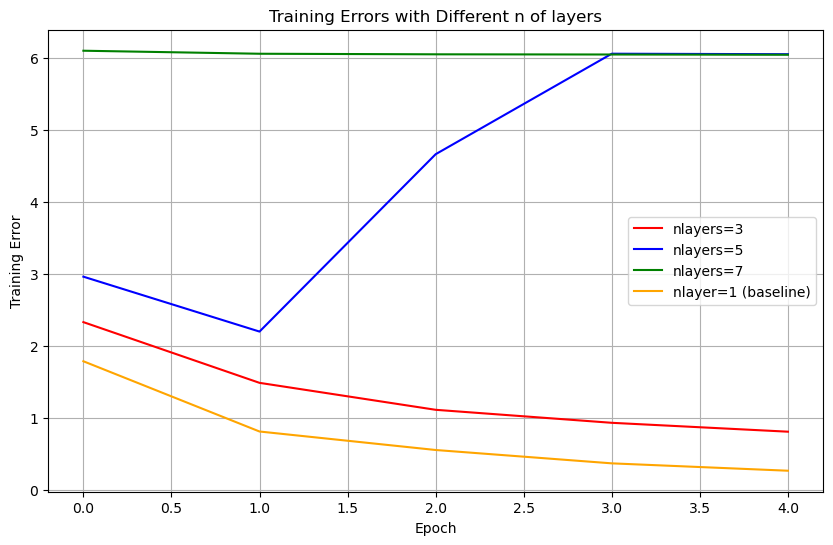

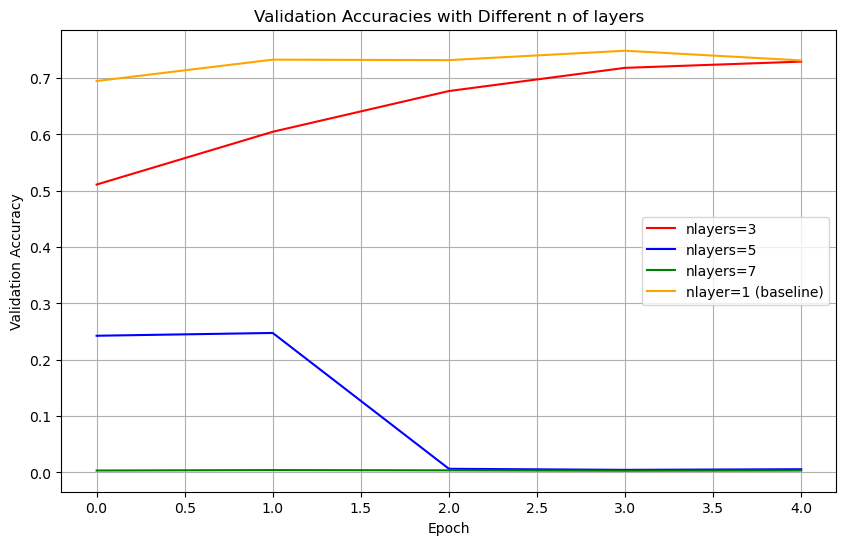

In [343]:
#FOR DIFFERENT N_LAYERS
csv_files = ['TASK_D_Baseline_var_3_layers_stats.csv', 'TASK_D_Baseline_var_5_layers_stats.csv', 'TASK_D_Baseline_var_7_layers_stats.csv', 'TASK_D_Baseline_var_1_layers_stats.csv']
label_names = ['nlayers=3', 'nlayers=5', 'nlayers=7', 'nlayer=1 (baseline)']
line_colors = ['red', 'blue', 'green', 'orange', 'purple']

epochs = []
training_errors = []
validation_accuracies = []

for file_name in csv_files:
    df = pd.read_csv(file_name)
    epochs.append(df['epoch'].values)
    training_errors.append(df['training_error'].values)
    validation_accuracies.append(df['validation_accuracy'].values)

#plot training errors
for i in range(len(csv_files)):
    plt.plot(epochs[i], training_errors[i], color=line_colors[i], label=label_names[i])

plt.xlabel('Epoch')
plt.ylabel('Training Error')
plt.title('Training Errors with Different n of layers')
plt.legend()
plt.grid(True)
plt.show()


#plot validation accuracies
for i in range(len(csv_files)):
    plt.plot(epochs[i], validation_accuracies[i], color=line_colors[i], label=label_names[i])

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracies with Different n of layers')
plt.legend()
plt.grid(True)
plt.show()


Surely different is the case concerning the choice of `n_layers_`. 1 and 3 are the values that ensure a positive test accuracy (relatively ~75% and ~73%), whereas a bigger number (≥5) not only requires an extensive amount of computation and time (we tried 10 layers but at the first epoch the validation accuracy was less than 0.3%, thus it has been desregarded), but results in an inefficient outcome. This result suggests that additional layers render higher complexity, leading to overfitting on this model.